<a href="https://colab.research.google.com/github/drdrwenski/sympy-examples/blob/main/MinkowskiMetric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Metric Tensor in Minkowski Space

The metric tensor in Minkowski space is fundamental to the structure and mathematics of special relativity. It defines the spacetime interval, which is invariant under Lorentz transformations, and provides the means to calculate proper time and distance. It ensures the consistency of physical laws across different inertial frames and underpins the entire framework of special relativity by defining the geometry of spacetime.

## Preliminaries

In [24]:
%pip install sympy_plot_backends

First, we define some output helper functions:

In [25]:
from sympy.tensor.tensor import Tensor, TensMul
from IPython.display import display, Markdown, HTML
from sympy import latex, simplify
import re

mathjaxURL = rf'<script type="text/javascript" src="https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.7/MathJax.js?config=TeX-MML-AM_CHTML"></script>'

def get_tensor_indices(expr):
  indices = []
  if isinstance(expr, Tensor):
    indices.extend(expr.get_indices())
  elif hasattr(expr, 'args'):
    for subexpr in expr.args:
      indices.extend(get_tensor_indices(subexpr))
  indices = list(dict.fromkeys(indices))
  return indices

def get_free_indices(expr):
  indices = []
  if isinstance(expr, TensMul):
    indices.extend(expr.get_free_indices())
  elif isinstance(expr, Tensor):
    indices.extend(expr.get_free_indices())
  elif hasattr(expr, 'args'):
    for subexpr in expr.args:
      indices.extend(get_free_indices(subexpr))
  indices = list(dict.fromkeys(indices))
  return indices

def prettyLatex(expr, **kwargs):
  output = rf'{latex(expr)}'
  repl = kwargs.get('repl', [])
  for old, new in repl:
    output = output.replace(old, new)
  indices = kwargs.get('indices', [])
  if (indices):
    expr_indices = get_tensor_indices(expr)
    free_indices = get_free_indices(expr)
    matches = indices.get('metric_name','L') + r'_(\d+)'
    replace = indices.get('metric_name','L') + r'_{\1}'
    dummy_indices = [ re.sub(matches, replace, index.name)
      for index in expr_indices if index not in free_indices ]
    dummy_indices = list(dict.fromkeys(dummy_indices))
    unused_indices = [rf'\{index.name}' for index in indices.get('tensor_indices',[])
      if index not in free_indices and -index not in free_indices ]
    for (i,j) in zip(dummy_indices, unused_indices):
      output = output.replace(i,j)
  return output

def displayLatex(expr, **kwargs):
  intro = kwargs.get('intro', '')
  coda = kwargs.get('coda', '')
  output = rf'$\displaystyle {intro} {prettyLatex(expr,**kwargs)} {coda}$'
  display(Markdown(output))
  # htmlOutput = rf'<p>$${intro} {prettyLatex(expr,**kwargs)} {coda}$$</p>'
  # display(HTML(mathjaxURL + htmlOutput))

def displayLinearTransformation(tensor, vector, dict, simplified=True, **kwargs):
  func = simplify if simplified else (lambda x: x)
  substitutions = kwargs.get('substitutions', [])
  holors = [ Matrix(func(holor.replace_with_arrays(dict).subs(substitutions)))
    for holor in [tensor, vector, tensor*vector] ]
  coda = rf'\;=\; {latex(holors[0])} \cdot {latex(holors[1])} \;=\; {latex(holors[2])}'
  indices = kwargs.get('indices', [])
  displayLatex(tensor*vector, indices=indices, coda=coda)
  return holors[2]

## Spacetime Coordinates

The Minkowski space consists of a set of events, denoted as $M$, where each event is a point in a four-dimensional manifold. For any $P\in M$, there exists a local time coordinate $t$ and three spatial coordinates $(x, y, z)$ that describe the neighborhood around the event $P$. These coordinates form a local frame of reference in the manifold $M$, allowing for the tools of **differential geometry** and **tensor calculus** to be applied. For the start, we consider **Cartesian coordinates** to introduce the well-known Minkowski metric.

In [26]:
from sympy import symbols
from sympy.diffgeom import Manifold, Patch, CoordSystem
from sympy.diffgeom import twoform_to_matrix, TensorProduct as TP

Minkowski = Manifold('M', 4)
SpaceTime = Patch('ST', Minkowski)
M4 = CoordSystem('Cartesian', SpaceTime, symbols('t x y z'))

dt, dx, dy, dz = M4.base_oneforms()
Lorentz_metric = TP(dt,dt) - TP(dx,dx) - TP(dy,dy) - TP(dz,dz)
displayLatex(Lorentz_metric, intro = 'ds^2 =\ ')
displayLatex(twoform_to_matrix(Lorentz_metric), intro = '(g_{ij}) = ')

<>:11: SyntaxWarning: invalid escape sequence '\ '
<>:11: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipython-input-1243620282.py:11: SyntaxWarning: invalid escape sequence '\ '


$\displaystyle ds^2 =\  \operatorname{d}t \otimes \operatorname{d}t - \operatorname{d}x \otimes \operatorname{d}x - \operatorname{d}y \otimes \operatorname{d}y - \operatorname{d}z \otimes \operatorname{d}z $

$\displaystyle (g_{ij}) =  \left[\begin{matrix}1 & 0 & 0 & 0\\0 & -1 & 0 & 0\\0 & 0 & -1 & 0\\0 & 0 & 0 & -1\end{matrix}\right] $

The metric of Minkowski space is a flat space **Lorentz metric**. The signature $(+,-,-,-)$ of the metric tensor reflects the fact that time has a different character than the spatial dimensions. The metric tensor transforms contravariant four-vectors into their covariant counterparts (and vice versa).

In [27]:
from sympy.tensor.tensor import TensorIndexType, TensorHead, tensor_indices
from sympy import Eq

# Define tensor index type for Lorentz indices
Lorentz = TensorIndexType('Lorentz', metric_name='g', dim=4)
g = Lorentz.metric

# Define tensor indices
mu, nu, alpha, beta = tensor_indices('mu nu alpha beta', Lorentz)
Lorentz_indices = {
    'tensor_indices': [alpha, beta, mu, nu],
    'metric_name': Lorentz.dummy_name
}

# Define a 4-vector V
four_vector = TensorHead('V', [Lorentz])

# Transform contravariant 4-vector
V_prime = g(-alpha, -beta) * four_vector(beta)
contraction = Eq(V_prime, V_prime.contract_metric(g))  # .canon_bp())
displayLatex(contraction, indices=Lorentz_indices)

# Apply the inverse metric tensor
V_prime = g(alpha, mu) *g(-mu, -nu) * four_vector(nu)
contraction = Eq(V_prime, V_prime.contract_metric(g))  # .canon_bp())
displayLatex(contraction, indices=Lorentz_indices)

$\displaystyle  g{}_{\alpha\beta}V{}^{\beta} = V{}_{\alpha} $

$\displaystyle  g{}^{\alpha\beta}g{}_{\beta\mu}V{}^{\mu} = V{}^{\alpha} $

Throughout this notebook, we assume **natural units** of length and time such that the numerical value for the speed of light becomes $c = 1$ in every reference frame. In particular, if $V = (t,x,y,z)$ denotes the vector difference between two events in Minkowski space, then the corresponding **spacetime interval** is formed as given below.

In [28]:
# Bundle replacements for tensor contractions
replacements = {
    Lorentz: twoform_to_matrix(Lorentz_metric),
    four_vector(mu): M4.base_scalars()
}

# Define spacetime interval
spacetime_interval = g(-mu, -nu) * four_vector(mu) * four_vector(nu)
contracted = spacetime_interval.contract_metric(g)
ds2 = contracted.replace_with_arrays(replacements)

displayLatex(Eq(spacetime_interval, contracted), indices=Lorentz_indices,
    intro = 'ds^2(V,V) =\ ', coda=rf' \ =\ {latex(ds2)}')

<>:13: SyntaxWarning: invalid escape sequence '\ '
<>:13: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipython-input-869759898.py:13: SyntaxWarning: invalid escape sequence '\ '


$\displaystyle ds^2(V,V) =\  g{}_{\alpha\beta}V{}^{\alpha}V{}^{\beta} = V{}^{\alpha}V{}_{\alpha}  \ =\ \mathbf{t}^{2} - \mathbf{x}^{2} - \mathbf{y}^{2} - \mathbf{z}^{2}$

## Lorentz Transformation

Isometries of the Minkowski space preserve the metric, $ds^2(V',W') = ds^2(V,W)$. Of particular interest is the group of **linear** isometries, the so-called **Lorentz group**.

<img src="lorentzTransf-20250516-101352.png" width="50%" align="" />

In [29]:
# Define tensor for the Lorentz transformation
Lambda_tensor = TensorHead('Lambda', [Lorentz, Lorentz])

# Apply the Lorentz transformation to the 4-vector
V_prime = Lambda_tensor(alpha, -beta) * four_vector(beta)
displayLatex(V_prime, indices=Lorentz_indices, intro='V\'^{\\,\\alpha} =\ ')

<>:6: SyntaxWarning: invalid escape sequence '\ '
<>:6: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipython-input-529289973.py:6: SyntaxWarning: invalid escape sequence '\ '


$\displaystyle V'^{\,\alpha} =\  \Lambda{}^{\alpha}{}_{\beta}V{}^{\beta} $

Lorentz transformations are coordinate transformations between two inertial reference frames. In the **standard configuration** we implicitly assume that the two inertial reference frames coincide at a given point in spacetime, presuming **clock synchronization** at $\; t = t' = 0\;$ and $\;(x,y,z) = (x',y',z') = 0$. Thus we eliminate the need for additional translation terms and focus solely on the effects of **relative motion** with constant, linear velocity ("Lorentz boosts").

In [30]:
from sympy import cosh, sinh, tanh, Matrix

# Define rapidity parameters
eta, zeta, xi = symbols('eta zeta xi')
beta0, beta1, beta2 = symbols('beta_:3')
gamma0, gamma1, gamma2 = symbols('gamma_:3')
combined_parameters = [(eta, beta0, gamma0), (zeta, beta1, gamma1), (xi, beta2, gamma2)]

# Define Lorentz factors for shorthand notation
lorentz_factors = []
for (rapidity, ratio_vc, lorentz_factor) in combined_parameters:
    lorentz_factors.append((cosh(rapidity), lorentz_factor))
    lorentz_factors.append((sinh(rapidity), ratio_vc * lorentz_factor))
    lorentz_factors.append((tanh(rapidity), ratio_vc))

# Define Lorentz transformation matrices
Lambda_matrices = [
    Matrix([
        [cosh(eta), -sinh(eta), 0, 0],
        [-sinh(eta), cosh(eta), 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ]),
    Matrix([
        [cosh(zeta), 0, -sinh(zeta), 0],
        [0, 1, 0, 0],
        [-sinh(zeta), 0, cosh(zeta), 0],
        [0, 0, 0, 1]
    ]),
    Matrix([
        [cosh(xi), 0, 0, -sinh(xi)],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [-sinh(xi), 0, 0, cosh(xi)]
    ])
]

Lorentz transformations preserve the spacetime interval (a "Lorentz invariant"). In particular, **timelike** separated events remain timelike separated, and all reference frames will agree on the causal ordering of such events.

<img src="spacetime_interval.jpg" width="" align="" />

In [31]:
from sympy import Wild

def replace_cosh2(expr):
    u = Wild('u')
    return expr.replace(cosh(u)**2, 1+sinh(u)**2)

replacements.update({
    Lambda_tensor(mu, -nu): Lambda_matrices[0]
})

V_prime_vector = displayLinearTransformation(
    Lambda_tensor(alpha, -beta), four_vector(beta),
    replacements, indices=Lorentz_indices)

spacetime_interval = g(-mu, -nu) * Lambda_tensor(mu, -beta) * four_vector(beta) * Lambda_tensor(nu, -alpha) * four_vector(alpha)
contracted = spacetime_interval.contract_metric(g)
ds2 = simplify(replace_cosh2(contracted.replace_with_arrays(replacements)))

displayLatex(spacetime_interval, indices=Lorentz_indices,
    intro='ds^2(V\',V\')\ =\ ', coda=rf'\ =\ {latex(ds2)}')

<>:20: SyntaxWarning: invalid escape sequence '\ '
<>:20: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipython-input-3743122021.py:20: SyntaxWarning: invalid escape sequence '\ '


$\displaystyle  \Lambda{}^{\alpha}{}_{\beta}V{}^{\beta} \;=\; \left[\begin{matrix}\cosh{\left(\eta \right)} & - \sinh{\left(\eta \right)} & 0 & 0\\- \sinh{\left(\eta \right)} & \cosh{\left(\eta \right)} & 0 & 0\\0 & 0 & 1 & 0\\0 & 0 & 0 & 1\end{matrix}\right] \cdot \left[\begin{matrix}\mathbf{t}\\\mathbf{x}\\\mathbf{y}\\\mathbf{z}\end{matrix}\right] \;=\; \left[\begin{matrix}- \sinh{\left(\eta \right)} \mathbf{x} + \cosh{\left(\eta \right)} \mathbf{t}\\- \sinh{\left(\eta \right)} \mathbf{t} + \cosh{\left(\eta \right)} \mathbf{x}\\\mathbf{y}\\\mathbf{z}\end{matrix}\right]$

$\displaystyle ds^2(V',V')\ =\  g{}_{\alpha\beta}\Lambda{}^{\alpha}{}_{\mu}V{}^{\mu}\Lambda{}^{\beta}{}_{\nu}V{}^{\nu} \ =\ \mathbf{t}^{2} - \mathbf{x}^{2} - \mathbf{y}^{2} - \mathbf{z}^{2}$

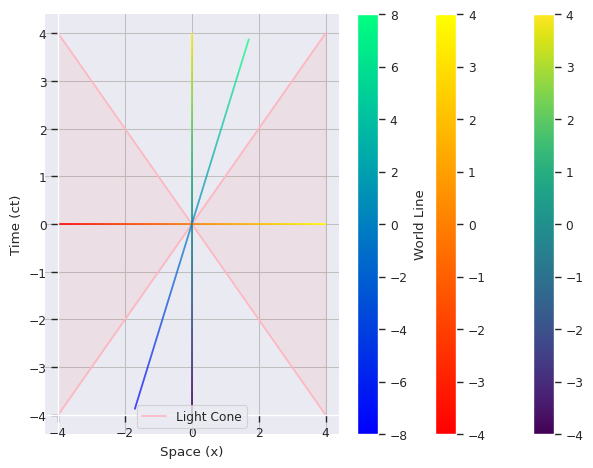

In [32]:
from sympy.plotting import plot, plot_parametric
from numpy import linspace
import seaborn as sns
from spb import plot, plot_parametric

sns.set_style('darkgrid')
sns.set_context('paper')

# Cartesian plotting variables
t, x, y, z = symbols('t x y z')

# Spacetime diagram without world lines
def getSpacetimeDiagram(xmin, xmax, ymin, ymax):
    x_array = linspace(-4, 4, 100)
    # Plotting light cones
    p = plot(x, -x, (x,xmin,xmax), axis_center=(xmin,ymin), aspect_ratio=(1,1),
            xlabel='Space (x)', ylabel='Time (ct)', line_color='lightpink',
            fill={'x': x_array, 'y1': x_array, 'y2': -x_array, 'color': 'red', 'alpha': 0.05},
            legend=True, show=False
        )
    # Plotting space and time axes
    p.extend(plot_parametric((0, t, (t,ymin,ymax)), (t, 0, (t,xmin,xmax)), line_color='grey', show=False))
    for line in p:
        line.label = ''
    p[0].label = 'Light Cone'
    return p

# Replacing base scalar fields by Cartesian plotting variables
plot_variables = list(zip(M4.base_scalars(), [t, x, y, z]))
plot_values = [(eta, 1), (x, 0.9*t)]
time_values = V_prime_vector[0].subs(plot_variables).subs(plot_values)
space_values = V_prime_vector[1].subs(plot_variables).subs(plot_values)

# Draw world line
p = getSpacetimeDiagram(-4, 4, -4, 4)
p.extend(plot_parametric(space_values, time_values, (t,-8,8), title='Spacetime Diagram', show=False))
p[-1].label = 'World Line'
p.show()

Time will always be shortest as measured in its rest frame. If $t$ is the rest frame's period of bell strokes after clock synchronization, then for the second observer in the moving frame the very same bell strokes happen at a later time $\gamma t$, indicating that the first observer's clock is going slower. **Note that**, so far, the situation is totally symmetric, since both reference frames are interchangeable in the above setting of relative motion.

In [33]:
# Define tensors for combined Lorentz transformations
Eta_tensor = TensorHead('Eta', [Lorentz, Lorentz])
Zeta_tensor = TensorHead('Zeta', [Lorentz, Lorentz])
Xi_tensor = TensorHead('Xi', [Lorentz, Lorentz])
clock_vector = TensorHead('W', [Lorentz])

# Update replacements dictionary
replacements.update({
    Eta_tensor(mu, -nu): Lambda_matrices[0],
    Zeta_tensor(mu, -nu): Lambda_matrices[1],
    Xi_tensor(mu, -nu): Lambda_matrices[2],
    clock_vector(mu): [M4.base_scalar(0), 0, 0, 0]
})

V_prime_combined = displayLinearTransformation(
    Xi_tensor(alpha, -mu) * Zeta_tensor(mu, -nu) * Eta_tensor(nu, -beta),
    clock_vector(beta),
    replacements, indices=Lorentz_indices, substitutions=lorentz_factors)

$\displaystyle  \Xi{}^{\alpha}{}_{\beta}\mathrm{Z}{}^{\beta}{}_{\mu}\mathrm{H}{}^{\mu}{}_{\nu}W{}^{\nu} \;=\; \left[\begin{matrix}\gamma_{0} \gamma_{1} \gamma_{2} & - \beta_{0} \gamma_{0} \gamma_{1} \gamma_{2} & - \beta_{1} \gamma_{1} \gamma_{2} & - \beta_{2} \gamma_{2}\\- \beta_{0} \gamma_{0} & \gamma_{0} & 0 & 0\\- \beta_{1} \gamma_{0} \gamma_{1} & \beta_{0} \beta_{1} \gamma_{0} \gamma_{1} & \gamma_{1} & 0\\- \beta_{2} \gamma_{0} \gamma_{1} \gamma_{2} & \beta_{0} \beta_{2} \gamma_{0} \gamma_{1} \gamma_{2} & \beta_{1} \beta_{2} \gamma_{1} \gamma_{2} & \gamma_{2}\end{matrix}\right] \cdot \left[\begin{matrix}\mathbf{t}\\0\\0\\0\end{matrix}\right] \;=\; \left[\begin{matrix}\gamma_{0} \gamma_{1} \gamma_{2} \mathbf{t}\\- \beta_{0} \gamma_{0} \mathbf{t}\\- \beta_{1} \gamma_{0} \gamma_{1} \mathbf{t}\\- \beta_{2} \gamma_{0} \gamma_{1} \gamma_{2} \mathbf{t}\end{matrix}\right]$

In special relativity the Galilean law of addition of velocities is replaced (at least for subsequent Lorentz boosts in the same direction) by a simple addition rule for a hyperbolic angle called **rapidity**. For a velocity $v$, the rapidity $\eta$ is defined such that $v = c \tanh \eta$.

In [34]:
# Adjusting Lorentz transformations to same direction
replacements.update({
    Eta_tensor(mu, -nu): Lambda_matrices[0],
    Zeta_tensor(mu, -nu): Lambda_matrices[0].subs(eta, zeta)
})

# Display Lorentz transformation
V_prime_rapid = displayLinearTransformation(
    Zeta_tensor(alpha, -mu) * Eta_tensor(mu, -nu), four_vector(nu),
    replacements, indices=Lorentz_indices)

$\displaystyle  \mathrm{Z}{}^{\alpha}{}_{\beta}\mathrm{H}{}^{\beta}{}_{\mu}V{}^{\mu} \;=\; \left[\begin{matrix}\cosh{\left(\eta + \zeta \right)} & - \sinh{\left(\eta + \zeta \right)} & 0 & 0\\- \sinh{\left(\eta + \zeta \right)} & \cosh{\left(\eta + \zeta \right)} & 0 & 0\\0 & 0 & 1 & 0\\0 & 0 & 0 & 1\end{matrix}\right] \cdot \left[\begin{matrix}\mathbf{t}\\\mathbf{x}\\\mathbf{y}\\\mathbf{z}\end{matrix}\right] \;=\; \left[\begin{matrix}- \sinh{\left(\eta + \zeta \right)} \mathbf{x} + \cosh{\left(\eta + \zeta \right)} \mathbf{t}\\- \sinh{\left(\eta + \zeta \right)} \mathbf{t} + \cosh{\left(\eta + \zeta \right)} \mathbf{x}\\\mathbf{y}\\\mathbf{z}\end{matrix}\right]$

## Doppler Effect

While the classical wave vector of a photon comprises only the spatial characteristics of its wave-like behavior, the corresponding 4-vector exhibits an additional spacetime component. For a light-source moving with velocity $v$ in the $x$-direction, the relativistic wave vector of the emitted photon is given by $(\omega, \pm\omega, 0, 0)$. Here the sign depends on whether the photon is emitted in the direction of motion or in the opposite direction.


In [35]:
wave_vector = TensorHead('K', [Lorentz])
omega = symbols('omega')

replacements.update({
    Lambda_tensor(mu, -nu): Lambda_matrices[0],
    wave_vector(mu): [omega, omega, 0, 0]
})

doppler_vector = displayLinearTransformation(
    Lambda_tensor(alpha, -beta), wave_vector(beta),
    replacements, indices=Lorentz_indices)

$\displaystyle  \Lambda{}^{\alpha}{}_{\beta}K{}^{\beta} \;=\; \left[\begin{matrix}\cosh{\left(\eta \right)} & - \sinh{\left(\eta \right)} & 0 & 0\\- \sinh{\left(\eta \right)} & \cosh{\left(\eta \right)} & 0 & 0\\0 & 0 & 1 & 0\\0 & 0 & 0 & 1\end{matrix}\right] \cdot \left[\begin{matrix}\omega\\\omega\\0\\0\end{matrix}\right] \;=\; \left[\begin{matrix}\omega e^{- \eta}\\\omega e^{- \eta}\\0\\0\end{matrix}\right]$

In [36]:
# Update replacements dictionary
replacements.update({
    Eta_tensor(mu, -nu): Lambda_matrices[0],
    Zeta_tensor(mu, -nu): Lambda_matrices[1],
    Xi_tensor(mu, -nu): Lambda_matrices[2]
})

doppler_vector_combined = displayLinearTransformation(
    Xi_tensor(alpha, -mu) * Zeta_tensor(mu, -nu) * Eta_tensor(nu, -beta),
    wave_vector(beta),
    replacements, indices=Lorentz_indices, substitutions=lorentz_factors[3:9])

$\displaystyle  \Xi{}^{\alpha}{}_{\beta}\mathrm{Z}{}^{\beta}{}_{\mu}\mathrm{H}{}^{\mu}{}_{\nu}K{}^{\nu} \;=\; \left[\begin{matrix}\gamma_{1} \gamma_{2} \cosh{\left(\eta \right)} & - \gamma_{1} \gamma_{2} \sinh{\left(\eta \right)} & - \beta_{1} \gamma_{1} \gamma_{2} & - \beta_{2} \gamma_{2}\\- \sinh{\left(\eta \right)} & \cosh{\left(\eta \right)} & 0 & 0\\- \beta_{1} \gamma_{1} \cosh{\left(\eta \right)} & \beta_{1} \gamma_{1} \sinh{\left(\eta \right)} & \gamma_{1} & 0\\- \beta_{2} \gamma_{1} \gamma_{2} \cosh{\left(\eta \right)} & \beta_{2} \gamma_{1} \gamma_{2} \sinh{\left(\eta \right)} & \beta_{1} \beta_{2} \gamma_{1} \gamma_{2} & \gamma_{2}\end{matrix}\right] \cdot \left[\begin{matrix}\omega\\\omega\\0\\0\end{matrix}\right] \;=\; \left[\begin{matrix}\gamma_{1} \gamma_{2} \omega e^{- \eta}\\\omega e^{- \eta}\\- \beta_{1} \gamma_{1} \omega e^{- \eta}\\- \beta_{2} \gamma_{1} \gamma_{2} \omega e^{- \eta}\end{matrix}\right]$

## Electromagnetic Tensor

The electromagnetic tensor, also known as the Faraday tensor, is a **second-rank tensor** that describes the electromagnetic field in a given spacetime. It unifies the electric and magnetic fields into a single mathematical object. The electromagnetic tensor is **antisymmetric**, reflecting the duality between the electric and magnetic fields.

In [37]:
from sympy.tensor.tensor import TensorSymmetry
from sympy import Rational, Eijk

# Define electromagnetic tensor
antisym = TensorSymmetry.fully_symmetric(-2)
F_tensor = TensorHead('F', [Lorentz, Lorentz], antisym)
displayLatex(F_tensor(alpha,beta))

# Define dual electromagnetic tensor
F_star = Rational(1,2) * (Lorentz.epsilon(-alpha,-beta,-mu,-nu) * F_tensor(mu,nu)).contract_metric(g)
displayLatex(F_star, intro=r'F^*_{\alpha\beta}=', indices=Lorentz_indices, repl=[('Eps', r'\epsilon')])

replacements.update({
    Lorentz.epsilon(-alpha,-beta,-mu,-nu): [ [ [ [
        Eijk(alpha,beta,mu,nu) for alpha in range(4)] for beta in range(4)] for mu in range(4)] for nu in range(4)]
})

$\displaystyle  F{}^{\alpha\beta} $

$\displaystyle F^*_{\alpha\beta}= \left(\frac{1}{2}\right)\epsilon{}_{\alpha\beta\mu\nu}F{}^{\mu\nu} $

The electromagnetic tensor can be expressed in terms of scalar and vector potential functions, representing the electrostatic and the magnetic component, respectively.

In [38]:
from sympy import Function
from sympy.diffgeom import Differential

# Define the four-potential
four_potential = [ Function(pot_name)(*M4.base_scalars())
  for pot_name in ('phi', 'A_x', 'A_y', 'A_z') ]

dA = Differential( sum([ four_potential[i] * M4.base_oneform(i) for i in range(4) ]) )
F_matrix = twoform_to_matrix(dA)
displayLatex(F_matrix)

$\displaystyle  \left[\begin{matrix}0 & - \left. \frac{d}{d \xi} A_{x}{\left(\xi,\mathbf{x},\mathbf{y},\mathbf{z} \right)} \right|_{\substack{ \xi=\mathbf{t} }} + \left. \frac{d}{d \xi} \phi{\left(\mathbf{t},\xi,\mathbf{y},\mathbf{z} \right)} \right|_{\substack{ \xi=\mathbf{x} }} & - \left. \frac{d}{d \xi} A_{y}{\left(\xi,\mathbf{x},\mathbf{y},\mathbf{z} \right)} \right|_{\substack{ \xi=\mathbf{t} }} + \left. \frac{d}{d \xi} \phi{\left(\mathbf{t},\mathbf{x},\xi,\mathbf{z} \right)} \right|_{\substack{ \xi=\mathbf{y} }} & - \left. \frac{d}{d \xi} A_{z}{\left(\xi,\mathbf{x},\mathbf{y},\mathbf{z} \right)} \right|_{\substack{ \xi=\mathbf{t} }} + \left. \frac{d}{d \xi} \phi{\left(\mathbf{t},\mathbf{x},\mathbf{y},\xi \right)} \right|_{\substack{ \xi=\mathbf{z} }}\\\left. \frac{d}{d \xi} A_{x}{\left(\xi,\mathbf{x},\mathbf{y},\mathbf{z} \right)} \right|_{\substack{ \xi=\mathbf{t} }} - \left. \frac{d}{d \xi} \phi{\left(\mathbf{t},\xi,\mathbf{y},\mathbf{z} \right)} \right|_{\substack{ \xi=\mathbf{x} }} & 0 & \left. \frac{d}{d \xi} A_{x}{\left(\mathbf{t},\mathbf{x},\xi,\mathbf{z} \right)} \right|_{\substack{ \xi=\mathbf{y} }} - \left. \frac{d}{d \xi} A_{y}{\left(\mathbf{t},\xi,\mathbf{y},\mathbf{z} \right)} \right|_{\substack{ \xi=\mathbf{x} }} & \left. \frac{d}{d \xi} A_{x}{\left(\mathbf{t},\mathbf{x},\mathbf{y},\xi \right)} \right|_{\substack{ \xi=\mathbf{z} }} - \left. \frac{d}{d \xi} A_{z}{\left(\mathbf{t},\xi,\mathbf{y},\mathbf{z} \right)} \right|_{\substack{ \xi=\mathbf{x} }}\\\left. \frac{d}{d \xi} A_{y}{\left(\xi,\mathbf{x},\mathbf{y},\mathbf{z} \right)} \right|_{\substack{ \xi=\mathbf{t} }} - \left. \frac{d}{d \xi} \phi{\left(\mathbf{t},\mathbf{x},\xi,\mathbf{z} \right)} \right|_{\substack{ \xi=\mathbf{y} }} & - \left. \frac{d}{d \xi} A_{x}{\left(\mathbf{t},\mathbf{x},\xi,\mathbf{z} \right)} \right|_{\substack{ \xi=\mathbf{y} }} + \left. \frac{d}{d \xi} A_{y}{\left(\mathbf{t},\xi,\mathbf{y},\mathbf{z} \right)} \right|_{\substack{ \xi=\mathbf{x} }} & 0 & \left. \frac{d}{d \xi} A_{y}{\left(\mathbf{t},\mathbf{x},\mathbf{y},\xi \right)} \right|_{\substack{ \xi=\mathbf{z} }} - \left. \frac{d}{d \xi} A_{z}{\left(\mathbf{t},\mathbf{x},\xi,\mathbf{z} \right)} \right|_{\substack{ \xi=\mathbf{y} }}\\\left. \frac{d}{d \xi} A_{z}{\left(\xi,\mathbf{x},\mathbf{y},\mathbf{z} \right)} \right|_{\substack{ \xi=\mathbf{t} }} - \left. \frac{d}{d \xi} \phi{\left(\mathbf{t},\mathbf{x},\mathbf{y},\xi \right)} \right|_{\substack{ \xi=\mathbf{z} }} & - \left. \frac{d}{d \xi} A_{x}{\left(\mathbf{t},\mathbf{x},\mathbf{y},\xi \right)} \right|_{\substack{ \xi=\mathbf{z} }} + \left. \frac{d}{d \xi} A_{z}{\left(\mathbf{t},\xi,\mathbf{y},\mathbf{z} \right)} \right|_{\substack{ \xi=\mathbf{x} }} & - \left. \frac{d}{d \xi} A_{y}{\left(\mathbf{t},\mathbf{x},\mathbf{y},\xi \right)} \right|_{\substack{ \xi=\mathbf{z} }} + \left. \frac{d}{d \xi} A_{z}{\left(\mathbf{t},\mathbf{x},\xi,\mathbf{z} \right)} \right|_{\substack{ \xi=\mathbf{y} }} & 0\end{matrix}\right] $

In Cartesian coordinates, the tensor has **six** independent components - the electric field vector and the magnetic field vector. Together, these components fully describe the electromagnetic field at any given point in spacetime.

In [39]:
E_x, E_y, E_z = symbols('E_x E_y E_z')
electric_field = [0, E_x, E_y, E_z]
grad_phi = [ Differential(four_potential[0])(e_base) for e_base in M4.base_vectors() ]
gauge_electric = [ M4.base_vector(0)(four_potential[i]) - grad_phi[i] for i in range(4) ]

B_x, B_y, B_z = symbols('B_x B_y B_z')
magnetic_field = [0, B_x, B_y, B_z]
curl_A = Differential( sum([ four_potential[i] * M4.base_oneform(i) for i in (1,2,3) ]))
gauge_magnetic = [ curl_A(M4.base_vector(j), M4.base_vector(k)) for (j,k) in ((0,0), (2,3), (3,1), (1,2)) ]

electric_repl = [ (gauge_electric[i], electric_field[i]) for i in range(4) ]
magnetic_repl = [ (gauge_magnetic[i], magnetic_field[i]) for i in range(4) ]
F_matrix = F_matrix.subs(electric_repl + magnetic_repl)
replacements.update({ F_tensor(alpha, beta): F_matrix })

displayLatex(F_tensor(alpha, beta).replace_with_arrays(replacements), intro=rf'{latex(F_tensor(alpha, beta))}=')
displayLatex(F_star.replace_with_arrays(replacements), intro=r'F^*_{\alpha\beta}=')

$\displaystyle F{}^{\alpha\beta}= \left[\begin{matrix}0 & - E_{x} & - E_{y} & - E_{z}\\E_{x} & 0 & - B_{z} & B_{y}\\E_{y} & B_{z} & 0 & - B_{x}\\E_{z} & - B_{y} & B_{x} & 0\end{matrix}\right] $

$\displaystyle F^*_{\alpha\beta}= \left[\begin{matrix}0 & - B_{x} & - B_{y} & - B_{z}\\B_{x} & 0 & - E_{z} & E_{y}\\B_{y} & E_{z} & 0 & - E_{x}\\B_{z} & - E_{y} & E_{x} & 0\end{matrix}\right] $

In [40]:
# Calculate Lorentz-invariants of the electromagnetic tensor
F_squared = F_tensor(-alpha,-beta) * F_tensor(beta,alpha)
displayLatex(Eq(F_squared, F_squared.replace_with_arrays(replacements)),
    intro=r'F^2=', indices=Lorentz_indices)

F_star_times_F = F_star * F_tensor(beta,alpha)
displayLatex(Eq(F_star_times_F, F_star_times_F.replace_with_arrays(replacements)),
    intro=r'F^* F=', indices=Lorentz_indices, repl=[('Eps', r'\epsilon')])

$\displaystyle F^2= F{}_{\alpha\beta}F{}^{\beta\alpha} = - 2 B_{x}^{2} - 2 B_{y}^{2} - 2 B_{z}^{2} + 2 E_{x}^{2} + 2 E_{y}^{2} + 2 E_{z}^{2} $

$\displaystyle F^* F= \left(\frac{1}{2}\right)\epsilon{}_{\alpha\beta\mu\nu}F{}^{\mu\nu}F{}^{\beta\alpha} = - 4 B_{x} E_{x} - 4 B_{y} E_{y} - 4 B_{z} E_{z} $

To describe a relativistic particle in an electric field using SymPy's tensor module, we need to consider the dynamics governed by the Lorentz force law in special relativity. The following code sets up the tensor framework to describe the dynamics of a relativistic particle in an electric field. The output will be the equations of motion, which describe how the components of the 4-velocity evolve over time due to the Lorentz force.

In [41]:
"""
from sympy.tensor.tensor import TensorSymmetry
from sympy import Function, diff, simplify

# Define electromagnetic field tensor components for an electric field
E_x, E_y, E_z = symbols('E_x E_y E_z')
B_x, B_y, B_z = symbols('B_x B_y B_z')
F = [
    [0, E_x, E_y, E_z],
    [-E_x, 0, B_z, -B_y],
    [-E_y, -B_z, 0, B_x],
    [-E_z, B_y, -B_x, 0]
]

# Define particle charge and 4-velocity components
q = symbols('q')
u0, u1, u2, u3 = symbols('u0 u1 u2 u3')
u_vec = TensorHead('u', [Lorentz])
replacements.update({u_vec(mu): [u0, u1, u2, u3]})

antisym = TensorSymmetry.fully_symmetric(-2)
F_up = TensorHead('F_up', [Lorentz, Lorentz], antisym)
replacements.update({F_up(mu, nu): F})

# Compute Lorentz force
f = q * (F_up(mu, nu) * u_vec(-nu)).replace_with_arrays(replacements)
displayLatex(f)

# Define mass of the particle and equations of motion
m = symbols('m')
du_dt = simplify(f / m)

# Display the results
for i in range(4):
    print(f"du{i}/dt = {du_dt[i]}")

"""

'\nfrom sympy.tensor.tensor import TensorSymmetry\nfrom sympy import Function, diff, simplify\n\n# Define electromagnetic field tensor components for an electric field\nE_x, E_y, E_z = symbols(\'E_x E_y E_z\')\nB_x, B_y, B_z = symbols(\'B_x B_y B_z\')\nF = [\n    [0, E_x, E_y, E_z],\n    [-E_x, 0, B_z, -B_y],\n    [-E_y, -B_z, 0, B_x],\n    [-E_z, B_y, -B_x, 0]\n]\n\n# Define particle charge and 4-velocity components\nq = symbols(\'q\')\nu0, u1, u2, u3 = symbols(\'u0 u1 u2 u3\')\nu_vec = TensorHead(\'u\', [Lorentz])\nreplacements.update({u_vec(mu): [u0, u1, u2, u3]})\n\nantisym = TensorSymmetry.fully_symmetric(-2)\nF_up = TensorHead(\'F_up\', [Lorentz, Lorentz], antisym)\nreplacements.update({F_up(mu, nu): F})\n\n# Compute Lorentz force\nf = q * (F_up(mu, nu) * u_vec(-nu)).replace_with_arrays(replacements)\ndisplayLatex(f)\n\n# Define mass of the particle and equations of motion\nm = symbols(\'m\')\ndu_dt = simplify(f / m)\n\n# Display the results\nfor i in range(4):\n    print(f"du{i}

## Spacetime Diagrams & Worldlines

Plotting worldlines in special relativity involves graphing the trajectories of particles in spacetime, typically on a 2D plot with time on the vertical axis and space on the horizontal axis. The following code demonstrates how to plot the worldlines of particles in special relativity using SymPy for symbolic computations and Matplotlib for visualization. The plot includes the original and Lorentz-transformed worldlines for comparison.

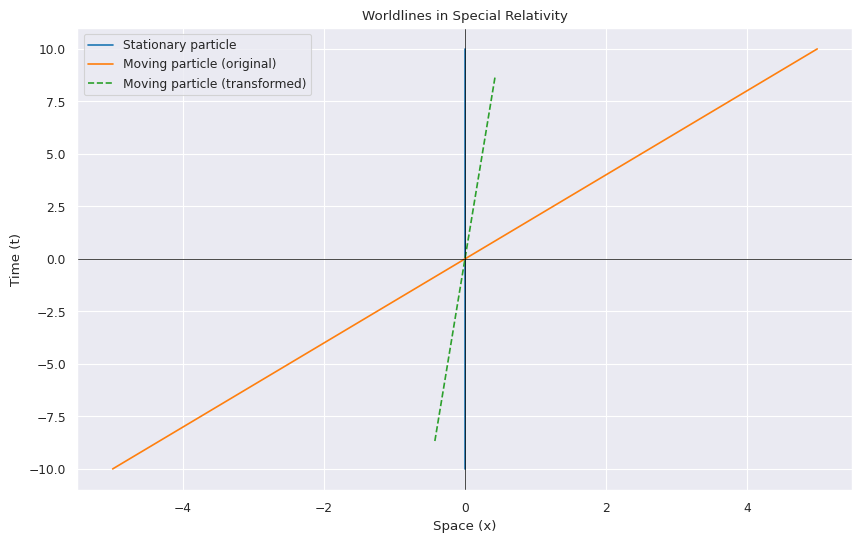

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import lambdify

# Lorentz transformation components
t_prime = cosh(eta) * t - sinh(eta) * x
x_prime = -sinh(eta) * t + cosh(eta) * x

# Convert to numerical functions
eta_val = 0.5  # Example value for rapidity
t_prime_func = lambdify((t, x), t_prime.subs(eta, eta_val), 'numpy')
x_prime_func = lambdify((t, x), x_prime.subs(eta, eta_val), 'numpy')

# Generate data for worldlines
t_vals = np.linspace(-10, 10, 400)

# Stationary particle
x_vals_stationary = np.zeros_like(t_vals)

# Moving particle
v = 0.5  # Speed as a fraction of the speed of light
x_vals_moving = v * t_vals

# Apply Lorentz transformation
t_prime_vals = t_prime_func(t_vals, x_vals_moving)
x_prime_vals = x_prime_func(t_vals, x_vals_moving)

# Plot the worldlines
plt.figure(figsize=(10, 6))

# Plot the stationary particle's worldline
plt.plot(x_vals_stationary, t_vals, label='Stationary particle')

# Plot the moving particle's worldline
plt.plot(x_vals_moving, t_vals, label='Moving particle (original)')
plt.plot(x_prime_vals, t_prime_vals, label='Moving particle (transformed)', linestyle='dashed')

# Labels and legend
plt.xlabel('Space (x)')
plt.ylabel('Time (t)')
plt.title('Worldlines in Special Relativity')
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
# plt.gca().set_aspect('equal')
plt.legend()
plt.grid(True)
plt.show()

**Note:** On a spacetime diagram, hyperbolas can represent lines of constant proper time.

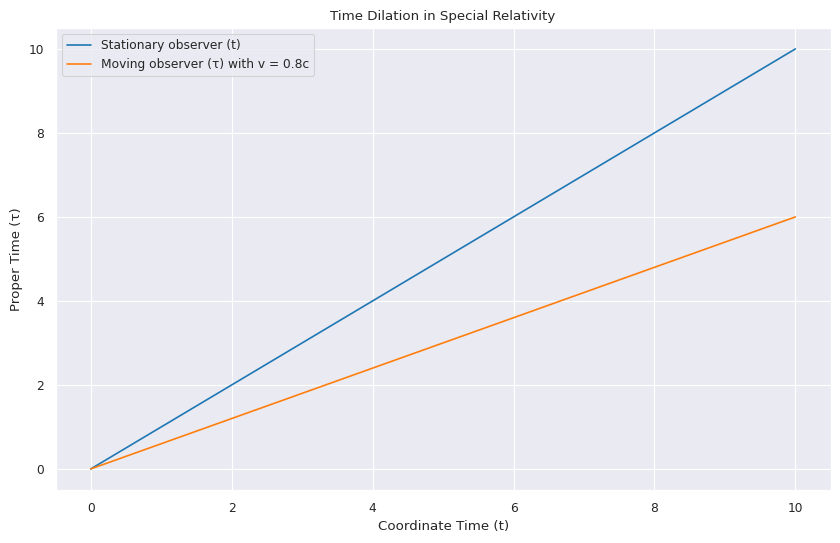

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import symbols, sqrt, lambdify

# Define symbols
t, v = symbols('t v')
gamma = 1 / sqrt(1 - v**2)

# Define proper time τ
tau = t / gamma

# Convert to numerical function
tau_func = lambdify((t, v), tau, 'numpy')

# Generate data
t_vals = np.linspace(0, 10, 400)
v_val = 0.8  # Example velocity as a fraction of the speed of light
tau_vals = tau_func(t_vals, v_val)

# Plot the worldlines and time dilation
plt.figure(figsize=(10, 6))

# Plot the coordinate time vs. proper time
plt.plot(t_vals, t_vals, label='Stationary observer (t)')
plt.plot(t_vals, tau_vals, label=f'Moving observer (τ) with v = {v_val}c')

# Labels and legend
plt.xlabel('Coordinate Time (t)')
plt.ylabel('Proper Time (τ)')
plt.title('Time Dilation in Special Relativity')
plt.legend()
plt.grid(True)
plt.show()

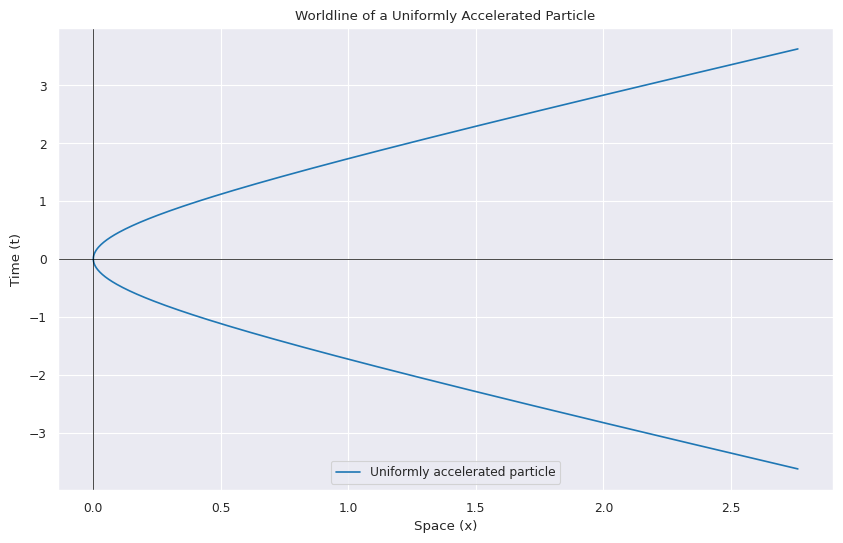

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import symbols, cosh, sinh, lambdify

# Define symbols
tau, a = symbols('tau a')

# Hyperbolic trajectory equations
x_tau = (cosh(a * tau) - 1) / a
t_tau = sinh(a * tau) / a

# Convert to numerical functions
a_val = 1.0  # Example value for proper acceleration
x_func = lambdify(tau, x_tau.subs(a, a_val), 'numpy')
t_func = lambdify(tau, t_tau.subs(a, a_val), 'numpy')

# Generate data for worldline
tau_vals = np.linspace(-2, 2, 400)
x_vals = x_func(tau_vals)
t_vals = t_func(tau_vals)

# Plot the worldline
plt.figure(figsize=(10, 6))

# Plot the worldline of the uniformly accelerated particle
plt.plot(x_vals, t_vals, label='Uniformly accelerated particle')

# Labels and legend
plt.xlabel('Space (x)')
plt.ylabel('Time (t)')
plt.title('Worldline of a Uniformly Accelerated Particle')
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.legend()
plt.grid(True)
plt.show()

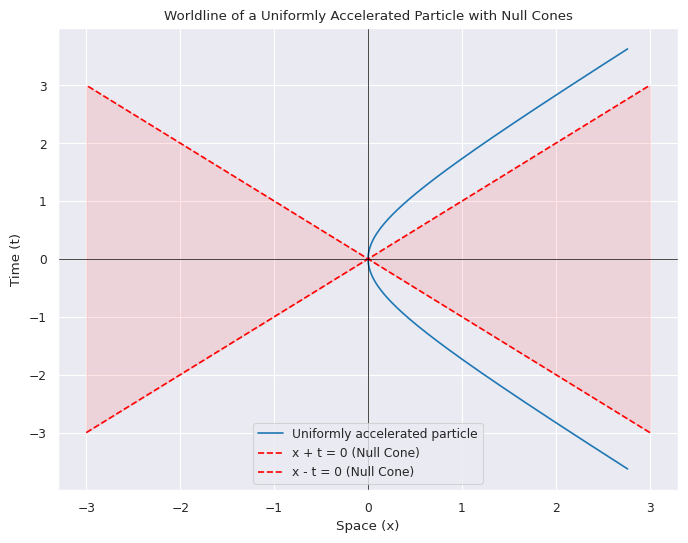

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import symbols, cosh, sinh, lambdify

# Define symbols
tau, a = symbols('tau a')

# Hyperbolic trajectory equations
x_tau = (cosh(a * tau) - 1) / a
t_tau = sinh(a * tau) / a

# Convert to numerical functions
a_val = 1.0  # Example value for proper acceleration
x_func = lambdify(tau, x_tau.subs(a, a_val), 'numpy')
t_func = lambdify(tau, t_tau.subs(a, a_val), 'numpy')

# Generate data for worldline
tau_vals = np.linspace(-2, 2, 400)
x_vals = x_func(tau_vals)
t_vals = t_func(tau_vals)

# Generate data for null cones
null_t_vals = np.linspace(-3, 3, 2)
null_x_plus_t = null_t_vals  # x + t = 0
null_x_minus_t = -null_t_vals  # x - t = 0

# Plot the worldline
plt.figure(figsize=(8, 6))

# Plot the worldline of the uniformly accelerated particle
plt.plot(x_vals, t_vals, label='Uniformly accelerated particle')

# Plot the null cones
plt.plot(null_x_plus_t, null_t_vals, 'r--', label='x + t = 0 (Null Cone)')
plt.plot(null_x_minus_t, null_t_vals, 'r--', label='x - t = 0 (Null Cone)')
plt.fill_between(null_t_vals, null_x_plus_t, null_x_minus_t, color='r', alpha=0.1, interpolate=True)

# Labels and legend
plt.xlabel('Space (x)')
plt.ylabel('Time (t)')
plt.title('Worldline of a Uniformly Accelerated Particle with Null Cones')
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.legend()
plt.grid(True)
plt.show()

> Visualize the electromagnetic field using the electromagnetic tensor components in a plot.

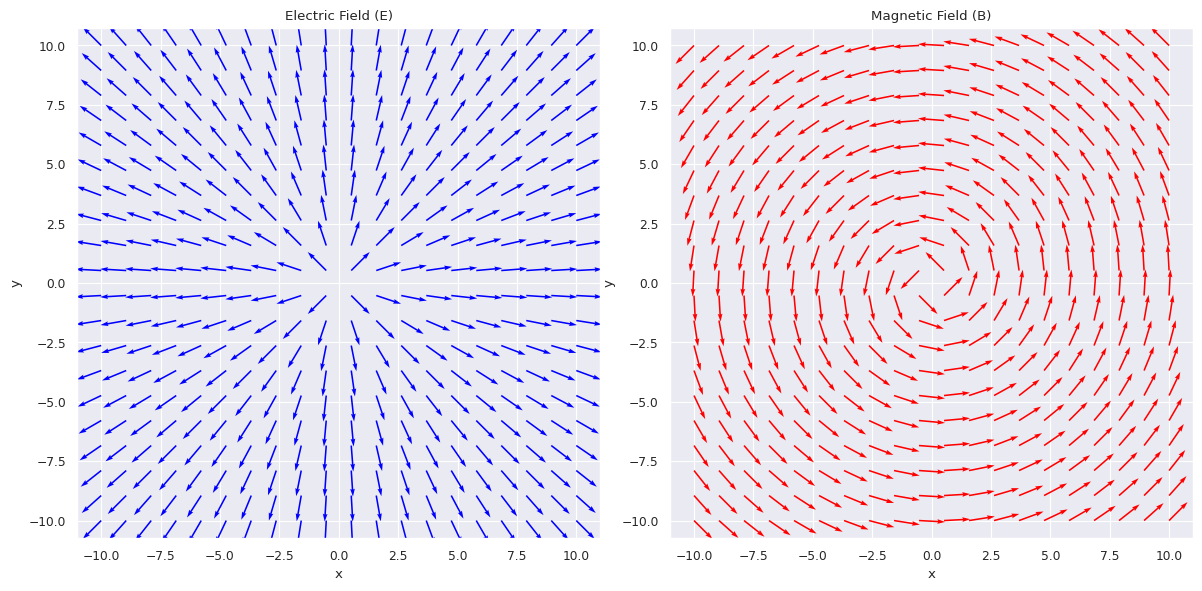

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# Define the grid for visualization
x = np.linspace(-10, 10, 20)
y = np.linspace(-10, 10, 20)
X, Y = np.meshgrid(x, y)

# Define the electric field components (E_x, E_y)
E_x = np.cos(np.arctan2(Y, X))
E_y = np.sin(np.arctan2(Y, X))

# Define the magnetic field components (B_x, B_y)
B_x = -np.sin(np.arctan2(Y, X))
B_y = np.cos(np.arctan2(Y, X))

# Create a figure for the plots
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot the electric field
ax[0].quiver(X, Y, E_x, E_y, color='blue', scale=20)
ax[0].set_title('Electric Field (E)')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].axis('equal')

# Plot the magnetic field
ax[1].quiver(X, Y, B_x, B_y, color='red', scale=20)
ax[1].set_title('Magnetic Field (B)')
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].axis('equal')

plt.tight_layout()
plt.show()

The visualization displays the electric field (E) and magnetic field (B) components using quiver plots. The electric field is represented in blue, while the magnetic field is shown in red. Both fields are plotted on a 2D grid.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b2b4ca2a-af01-4555-80d1-14c6a6cbeed3' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>